# Lesson 6 - Multi-LoRA


In this lesson, we'll see how to efficiently serve dozens of fine-tuned models together in a single deployment without sacrificing latency.

### Import required packages

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

### Let's create a new model

We will start with creating an extension to the model from lesson 5. It has a custom helper function for computing the LoRA layer step with multiple LoRAs per batch.

In [2]:
class AbstractMultiLoraModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # hidden_size = 10
        # set this so low to ensure we are not 
        # compute-bound by the linear layer
        # this is only an issue when running on CPU, 
        # for GPUs we can set this much
        # higher and still avoid being compute bound
        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, rank)
        loras_b: torch.Tensor,           # (num_loras, rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        # y[i] = x[i] @ loras_a[lora_idx] @ loras_b[lora_idx]
        raise NotImplementedError()

    def forward(self, input_ids, loras_a, loras_b, lora_indices):
        x = self.embedding(input_ids)
        x = self.linear_lora(x, loras_a, loras_b, lora_indices)
        x = self.lm_head(x)
        return x

### Using a loop

Our first attempt to infer across multiple LoRAs will be straightforward: just loop over every row in the batch and apply the correct LoRA using an index mapping: `batch_index --> lora_index`.

In [3]:
class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        for batch_idx, lora_idx in enumerate(lora_indices.numpy()):
            lora_a = loras_a[lora_idx]
            lora_b = loras_b[lora_idx]
            y[batch_idx] += x[batch_idx] @ lora_a @ lora_b
        return y

In [4]:
# toy example of a detokenizer. The vocabular only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [5]:
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [6]:
torch.manual_seed(42)

In [7]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [8]:
model = LoopMultiLoraModel()

### Let's try it!

We will try this over a few random LoRAs using a fixed tensor of input_ids. If our multi-LoRA generation process is working as designed, we should see a variety of different outputs generated as we randomly iterate over the LoRAs.

In [9]:
# constants
bs = 1
num_loras = 64
h = 10
r = 2

# create contiguous blocks for 64 random LoRA weights
loras_a = torch.randn(num_loras, h, r)
loras_b = torch.randn(num_loras, r, h)

for i in range(10):
    # randomize the LoRAs each iteration
    lora_indices = torch.randint(num_loras, (bs,), dtype=torch.long)
    next_token = generate_token(
        model,
        input_ids=input_ids,
        loras_a=loras_a,
        loras_b=loras_b,
        lora_indices=lora_indices,
    )
    print(next_token)

['orange']
['red']
['chartreuse']
['yellow']
['marigold']
['yellow']
['red']
['orange']
['violet']
['red']


### Let's benchmark our multi-LoRA system!

We will measure the average latency to generate a single token as the batch size increases and each element within the batch can have a different LoRA adapter (chosen randomly).

In [10]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64


def benchmark(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size, (bs, seq_len), dtype=torch.long)
            lora_indices = torch.randint(
                num_loras, (bs,), dtype=torch.long)

            # measure the end-to-end latency for 
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices,
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies

**Note:** Your results might differ from those shown in the video, but they will still follow the same pattern.

In [11]:
avg_latencies_loop = benchmark(model)

1 0.0001378173828125
2 0.0001707162857055664
3 0.00016969823837280273
4 0.0001935725212097168
5 0.00023235368728637696
6 0.00024792671203613284
7 0.0002855405807495117
8 0.0002953944206237793
9 0.00030487060546875
10 0.00033524703979492186
11 0.0003652205467224121
12 0.0003861560821533203
13 0.0004303889274597168
14 0.0004181675910949707
15 0.00044370174407958984
16 0.000493293285369873
17 0.0005306191444396973
18 0.0005229482650756836
19 0.0005610122680664063
20 0.0005640387535095215
21 0.000607351303100586
22 0.0006282129287719727
23 0.0006234974861145019
24 0.0006571402549743653
25 0.0006849589347839355
26 0.0007356295585632325
27 0.0007688727378845215
28 0.0007946677207946777
29 0.0007931842803955079
30 0.0007697606086730957
31 0.0008588557243347168
32 0.0008304324150085449
33 0.0008718585968017578
34 0.0008711609840393067
35 0.0008982634544372559
36 0.0010684690475463868
37 0.0011349692344665527
38 0.0011550097465515138
39 0.0010806660652160644
40 0.0010315017700195312
41 0.001112

### Let's visualize it!

**Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

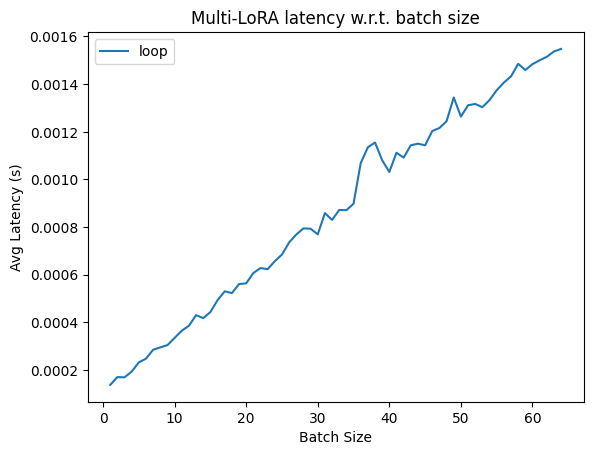

In [12]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

### Let's vectorize the LoRA computation

We will vectorize the LoRA computation by:

1. Gather the LoRA weight for each batch into a single tensor using `torch.index_select`.
2. Apply LoRA computation once for the entire input tensor.

In [13]:
class GatheredMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        
        # gather the LoRA weights into a new tensor and apply
        lora_a = torch.index_select(loras_a, 0, lora_indices) # (batch_size, in_features, lora_rank)
        lora_b = torch.index_select(loras_b, 0, lora_indices) # (batch_size, lora_rank, out_features)
        y += x @ lora_a @ lora_b
        return y

In [14]:
model = GatheredMultiLoraModel()

**Note:** Your results might differ from those shown in the video, but they will still follow the same pattern.

In [15]:
avg_latencies_gathered = benchmark(model)

1 0.00013459396362304688
2 0.002164257526397705
3 0.0022032432556152344
4 0.001991424083709717
5 0.0020047240257263185
6 0.001987138271331787
7 0.002383075714111328
8 0.0019982810020446776
9 0.0018358030319213868
10 0.002188999652862549
11 0.002563892841339111
12 0.002392944812774658
13 0.002378297805786133
14 0.0024136486053466795
15 0.002375190258026123
16 0.002374471187591553
17 0.0023876972198486326
18 0.0023939681053161623
19 0.002380338668823242
20 0.002414475917816162
21 0.002576235771179199
22 0.0029679837226867676
23 0.0028239340782165528
24 0.003182462215423584
25 0.0031651697158813475
26 0.003177494525909424
27 0.0031710267066955566
28 0.0027932744026184083
29 0.0029531378746032715
30 0.0029777488708496096
31 0.003571716785430908
32 0.0029865593910217286
33 0.002974442481994629
34 0.002809666633605957
35 0.0029839000701904297
36 0.0029730491638183592
37 0.0029780678749084474
38 0.0028070025444030763
39 0.00298643684387207
40 0.0027966256141662596
41 0.0033711795806884767
42 

### Let's visualize it!

**Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

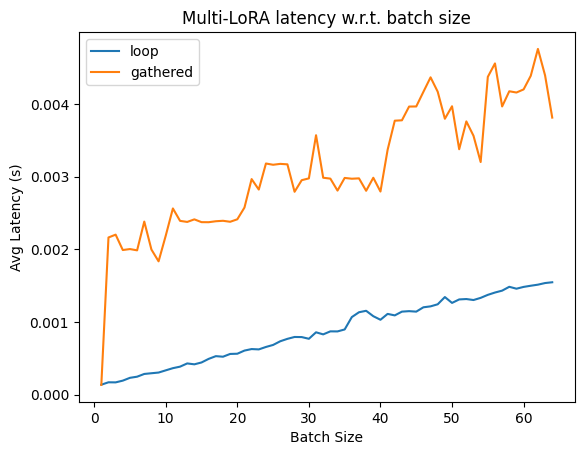

In [16]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gathered, label="gathered")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()